In [1]:
#Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

#visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#tf libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten,GlobalAveragePooling2D
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam,AdamW, RMSprop
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing
# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
#helper function
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2023-12-12 17:22:46--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-12-12 17:22:46 (77.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
spices_data = '../input/indo-spices-new/Indonesian_Spices_DatasetV4/'
walk_through_dir(spices_data)

There are 26 directories and 0 images in '../input/indo-spices-new/Indonesian_Spices_DatasetV4/'.
There are 0 directories and 200 images in '../input/indo-spices-new/Indonesian_Spices_DatasetV4/kemukus'.
There are 0 directories and 186 images in '../input/indo-spices-new/Indonesian_Spices_DatasetV4/kayu secang'.
There are 0 directories and 207 images in '../input/indo-spices-new/Indonesian_Spices_DatasetV4/kunyit'.
There are 0 directories and 206 images in '../input/indo-spices-new/Indonesian_Spices_DatasetV4/jahe'.
There are 0 directories and 211 images in '../input/indo-spices-new/Indonesian_Spices_DatasetV4/lada'.
There are 0 directories and 201 images in '../input/indo-spices-new/Indonesian_Spices_DatasetV4/asam_jawa'.
There are 0 directories and 203 images in '../input/indo-spices-new/Indonesian_Spices_DatasetV4/pala'.
There are 0 directories and 200 images in '../input/indo-spices-new/Indonesian_Spices_DatasetV4/adas'.
There are 0 directories and 216 images in '../input/indo-spic

In [4]:
img_directory = Path(spices_data)
filepaths = list(img_directory.glob(r'**/*.JPG')) + list(img_directory.glob(r'**/*.jpg')) + list(img_directory.glob(r'**/*.png')) + list(img_directory.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [5]:
image_df

Filepath        Label
0     ../input/indo-spices-new/Indonesian_Spices_Dat...  kayu secang
1     ../input/indo-spices-new/Indonesian_Spices_Dat...  kayu secang
2     ../input/indo-spices-new/Indonesian_Spices_Dat...  kayu secang
3     ../input/indo-spices-new/Indonesian_Spices_Dat...  kayu secang
4     ../input/indo-spices-new/Indonesian_Spices_Dat...  kayu secang
...                                                 ...          ...
5248  ../input/indo-spices-new/Indonesian_Spices_Dat...   kayu manis
5249  ../input/indo-spices-new/Indonesian_Spices_Dat...   kayu manis
5250  ../input/indo-spices-new/Indonesian_Spices_Dat...   kayu manis
5251  ../input/indo-spices-new/Indonesian_Spices_Dat...       kemiri
5252  ../input/indo-spices-new/Indonesian_Spices_Dat...       kemiri

[5253 rows x 2 columns]

**VISUALIZE THE DATASET**

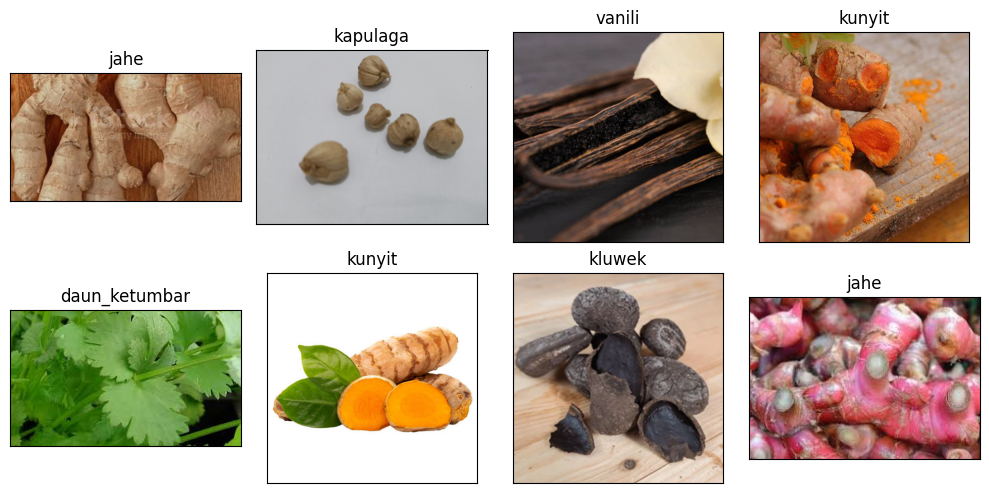

In [6]:
# Display 8 pictures of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 8)

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 5),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img = plt.imread(image_df['Filepath'].iloc[random_index[i]])
    ax.imshow(img)
    ax.set_title(image_df['Label'].iloc[random_index[i]])

plt.tight_layout()
plt.show()

In [7]:
#separate to training, validation, testing
training_dataset, testing_dataset = train_test_split(image_df, test_size=0.1, shuffle=True, random_state=1)
training_dataset, validation_dataset = train_test_split(training_dataset,test_size=0.2, shuffle=True, random_state=1)

In [8]:
train_generator = ImageDataGenerator(
    rescale=(1.0/255),
    rotation_range=20,      # Degree range for random rotations
    width_shift_range=0.3,  # Fraction of total width for random horizontal shift
    height_shift_range=0.3, # Fraction of total height for random vertical shift
    shear_range=0.3,        # Shear intensity (shear angle in radians)
    zoom_range=0.3,         # Random zoom range
    horizontal_flip=True,   # Randomly flip inputs horizontally
    fill_mode='nearest'
)

validation_generator = ImageDataGenerator(
   rescale=(1.0/255)
)

test_generator = ImageDataGenerator(
    rescale=(1.0/255.0)
)

In [9]:
training_images = train_generator.flow_from_dataframe(
dataframe = training_dataset,
x_col='Filepath',
y_col = 'Label',
target_size=(224,224),
color_mode='rgb',
class_mode='categorical',
batch_size=32,
shuffle=True,
seed=42,
subset='training')

validation_images = validation_generator.flow_from_dataframe(
dataframe = validation_dataset,
x_col='Filepath',
y_col = 'Label',
target_size=(224,224),
color_mode='rgb',
class_mode='categorical',
batch_size=32,
shuffle=True,
seed=42)

test_images = test_generator.flow_from_dataframe(
dataframe = testing_dataset,
x_col='Filepath',
y_col = 'Label',
target_size=(224,224),
color_mode='rgb',
class_mode='categorical',
batch_size=32,
shuffle=False)

Found 3781 validated image filenames belonging to 26 classes.
Found 946 validated image filenames belonging to 26 classes.
Found 526 validated image filenames belonging to 26 classes.


In [10]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(224,224),
    layers.experimental.preprocessing.Rescaling(1./255),
])

augmented = keras.Sequential([
    tf.keras.layers.RandomBrightness(0.2),
    tf.keras.layers.RandomContrast(0.2)
], name="data_augmentation")

2023-12-12 17:22:55.736487: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-12 17:22:55.736612: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-12 17:22:55.736684: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-12 17:22:55.736749: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-12 17:22:55.736826: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-12 17:22:55.737080: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-12 17:22:55.737181: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

In [11]:
input_shape = (224, 224, 3)

# Create Inception model
Base_Model = InceptionV3(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet'
)
# Freeze the layers of the pre-trained model
for layer in Base_Model.layers[-14:]:
    layer.trainable = True
# # Find the index of the layer you want to start training from
# start_layer_name = 'conv5_block2_3_conv'
# start_layer_index = None
# for i, layer in enumerate(Base_Model.layers):
#     if layer.name == start_layer_name:
#         start_layer_index = i
#         break

# # Make only the specified layers trainable
# for layer in Base_Model.layers[:start_layer_index]:
#     layer.trainable = False

# Display the summary of the model
Base_Model.summary()


87910968/87910968 [==============================] - 0s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activatio

In [12]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 5 epochs
early_stopping = EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=5,
                                                  restore_best_weights=True) # if val loss decreases for 3 epochs in a row, stop training

In [13]:
print(Base_Model.input)

KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


In [14]:
def build_model(base_model, num_classes):
    # Resize and rescale input images
    x = resize_and_rescale(base_model.input)
    
    # Apply data augmentation
    x = augmented(x)
    
    # Get the output from the base model
    base_model_output = base_model.output
    
    # Add your custom layers
    x = GlobalAveragePooling2D()(base_model_output)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    # Output layer
    outputs = Dense(num_classes, activation='softmax')(x)
    
    # Create the model
    model = Model(inputs=base_model.input, outputs=outputs)
    
    return model

# Assuming Base_Model is your pre-trained InceptionV3 model
model = build_model(Base_Model, 26)

# Compile model
model.compile(
    optimizer=Adam(1e-04),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [15]:
# Melatih model
history = model.fit(
    training_images,
    steps_per_epoch=len(training_images),
    validation_data=validation_images,
    validation_steps=len(validation_images),
    epochs=50
)

Epoch 1/50
119/119 [==============================] - 186s 1s/step - loss: 2.2266 - accuracy: 0.3848 - val_loss: 1.0713 - val_accuracy: 0.6765
Epoch 2/50
119/119 [==============================] - 159s 1s/step - loss: 1.0598 - accuracy: 0.7236 - val_loss: 0.5264 - val_accuracy: 0.8436
Epoch 3/50
119/119 [==============================] - 157s 1s/step - loss: 0.7546 - accuracy: 0.8165 - val_loss: 0.4626 - val_accuracy: 0.8816
Epoch 4/50
119/119 [==============================] - 157s 1s/step - loss: 0.6518 - accuracy: 0.8397 - val_loss: 0.5127 - val_accuracy: 0.8647
Epoch 5/50
119/119 [==============================] - 158s 1s/step - loss: 0.5485 - accuracy: 0.8545 - val_loss: 0.3787 - val_accuracy: 0.9038
Epoch 6/50
119/119 [==============================] - 157s 1s/step - loss: 0.4931 - accuracy: 0.8794 - val_loss: 0.5078 - val_accuracy: 0.8795
Epoch 7/50
119/119 [==============================] - 157s 1s/step - loss: 0.4516 - accuracy: 0.8887 - val_loss: 0.3488 - val_accuracy: 0.9218

In [16]:
results = model.evaluate(test_images, verbose=2)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

17/17 - 6s - loss: 0.4677 - accuracy: 0.8878 - 6s/epoch - 366ms/step
    Test Loss: 0.46767
Test Accuracy: 88.78%


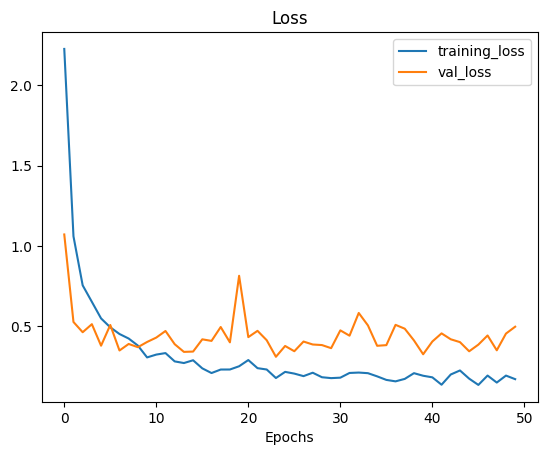

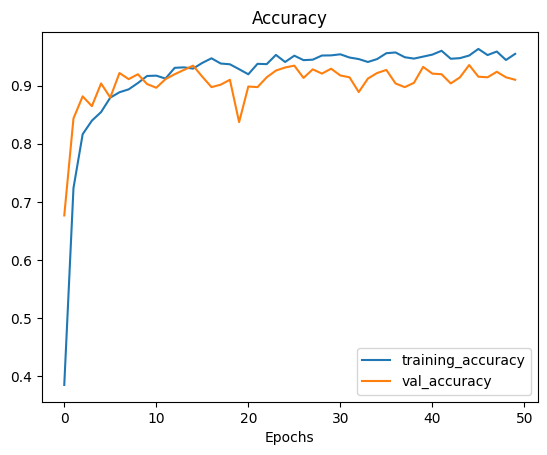

In [17]:
plot_loss_curves(history)

In [18]:
model.save('train_model_mobileNetV3_New.h5')

/usr/local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [19]:
history.history #Return Dictionary of history

{'loss': [2.226634979248047,
  1.0598176717758179,
  0.7545958757400513,
  0.6517680287361145,
  0.5485166311264038,
  0.4930955171585083,
  0.4516065716743469,
  0.42328760027885437,
  0.3794514238834381,
  0.3057536482810974,
  0.32339322566986084,
  0.3327343463897705,
  0.2809584140777588,
  0.2707133889198303,
  0.2879875898361206,
  0.23760272562503815,
  0.20842903852462769,
  0.23024435341358185,
  0.23049362003803253,
  0.2507008910179138,
  0.2893778085708618,
  0.2388450652360916,
  0.23043569922447205,
  0.17740905284881592,
  0.21572226285934448,
  0.20497803390026093,
  0.18924768269062042,
  0.21044176816940308,
  0.18238510191440582,
  0.17681799829006195,
  0.17962276935577393,
  0.20898360013961792,
  0.21142736077308655,
  0.20761507749557495,
  0.1878112107515335,
  0.16569849848747253,
  0.15670165419578552,
  0.1719508022069931,
  0.20765303075313568,
  0.19160448014736176,
  0.18168377876281738,
  0.1357240080833435,
  0.19942939281463623,
  0.2245260328054428,
 

In [20]:
#Recording History in json
import json
with open('train_hist_mobileNetV3_New.json','w') as f:
  json.dump(history.history,f)

In [21]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [22]:
print("Validation set Accuracy: {} %".format(history.history['val_accuracy'][-1]*100))

Validation set Accuracy: 91.01479649543762 %


In [23]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (training_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

17/17 [==============================] - 5s 203ms/step
The first 5 predictions: ['kemiri', 'jahe', 'kluwek', 'asam_jawa', 'pala']


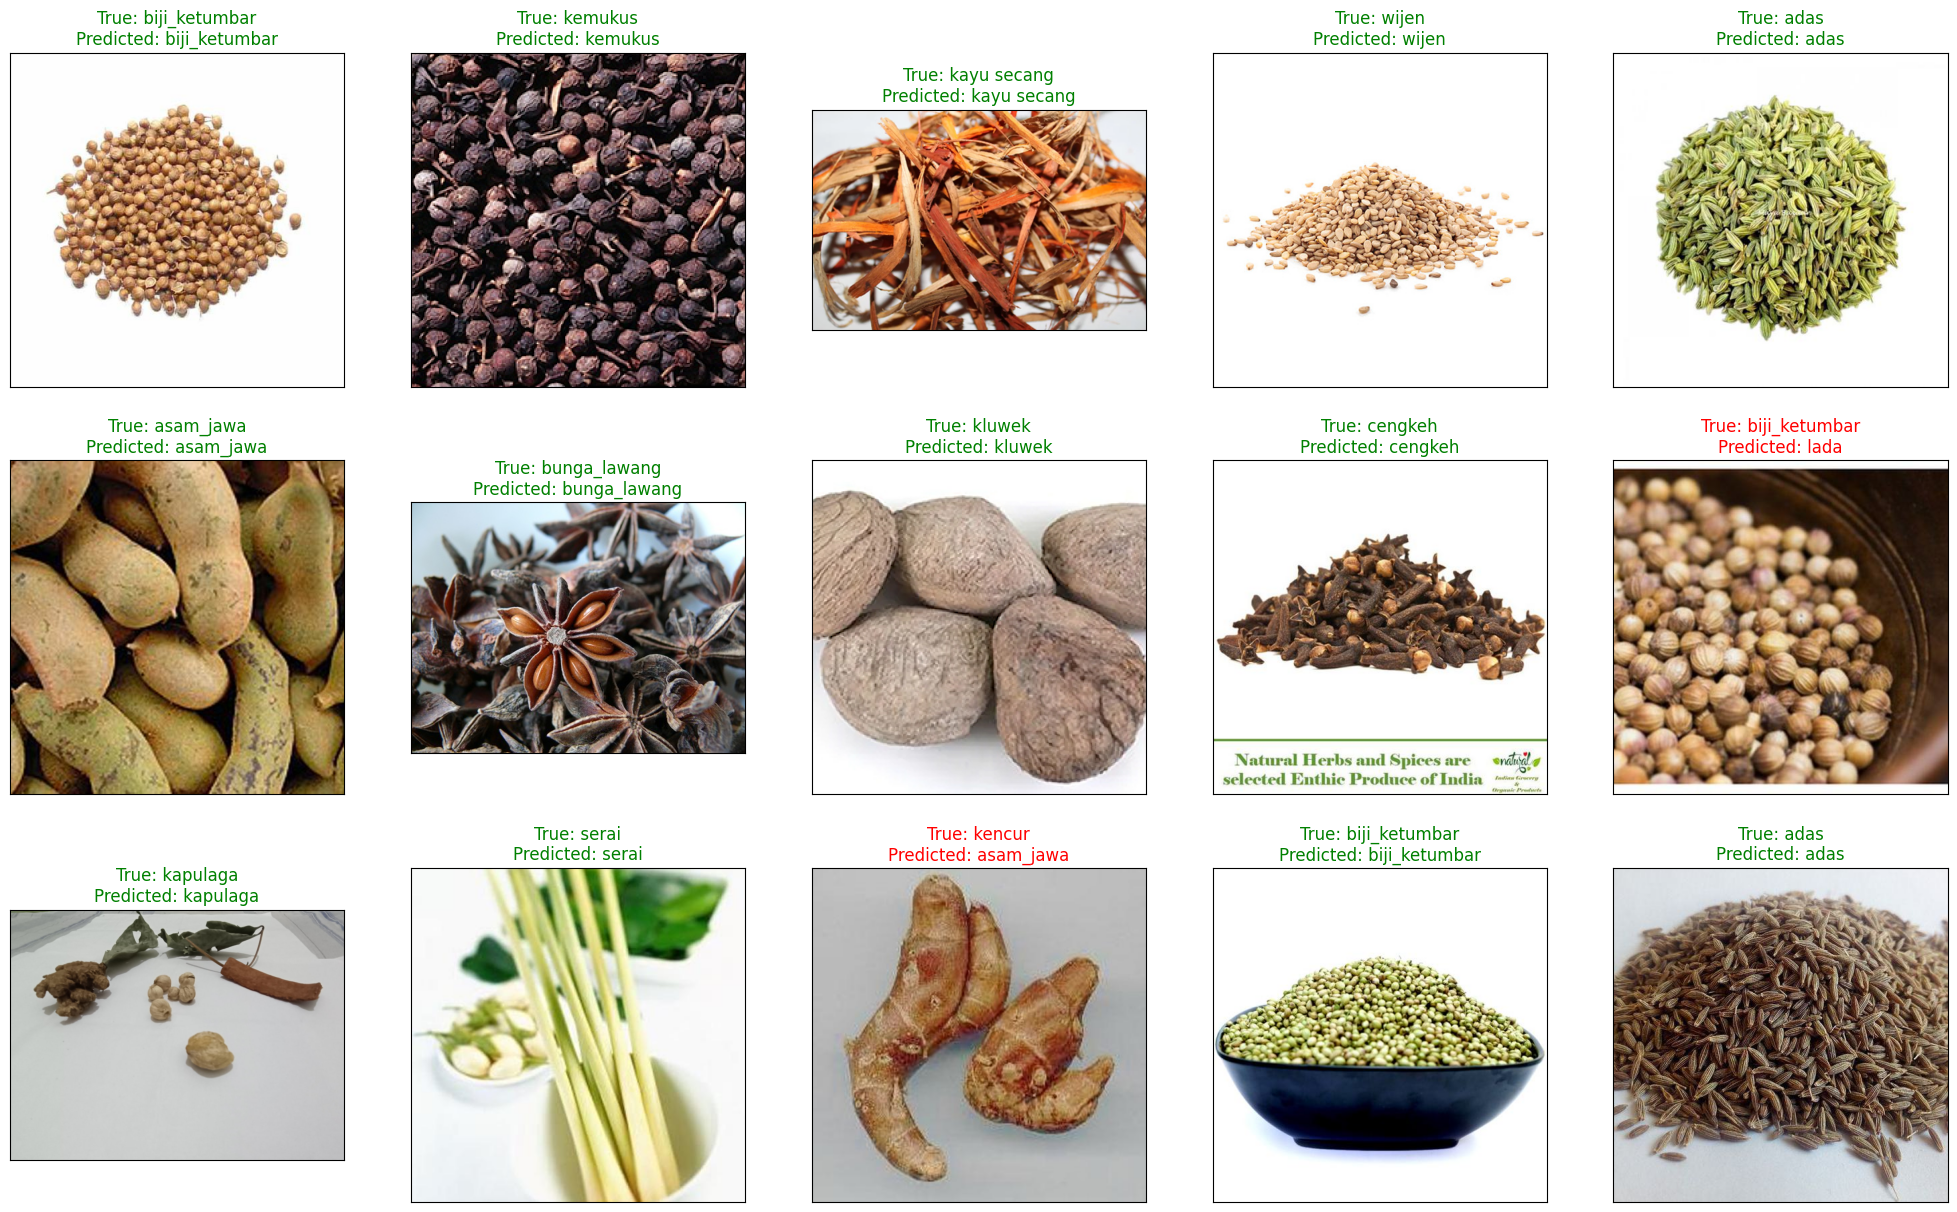

<Figure size 640x480 with 0 Axes>

In [24]:
  # Display 15 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(testing_dataset) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(testing_dataset.Filepath.iloc[random_index[i]]))
    if testing_dataset.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {testing_dataset.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [25]:
y_test = list(testing_dataset.Label)
print(classification_report(y_test, pred))

               precision    recall  f1-score   support

         adas       1.00      0.90      0.95        31
    andaliman       1.00      0.86      0.92        14
    asam_jawa       0.85      0.88      0.87        26
biji_ketumbar       0.78      0.61      0.68        23
 bukan_rempah       1.00      0.80      0.89        15
 bunga_lawang       0.96      0.96      0.96        28
      cengkeh       1.00      0.73      0.84        22
daun_ketumbar       0.85      0.94      0.89        18
   daun_salam       1.00      0.75      0.86        20
         jahe       1.00      0.94      0.97        16
       jinten       0.62      0.91      0.74        11
     kapulaga       0.85      0.85      0.85        13
   kayu manis       0.90      0.95      0.93        20
  kayu secang       0.93      0.88      0.90        16
       kemiri       0.85      0.92      0.88        25
      kemukus       0.75      0.95      0.84        19
       kencur       0.94      0.70      0.80        23
       kl

In [26]:
#Convert to TF LITE
import tensorflow as tf
import pathlib

model = tf.keras.models.load_model('train_model_mobileNetV3.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Specify a file name for the TFLite model
tflite_model_file = pathlib.Path('D:\Indonesian_Spices\model_mobileNetV3.tflite')

# Save the TFLite model to a file
tflite_model_file.write_bytes(tflite_model)


OSError: No file or directory found at train_model_mobileNetV3.h5